##1. Install NLTK, download the data and embeddings

I gdown the data to so you don't have to mount Drive.

In [14]:
%%capture
!pip install nltk
!gdown 11aG3KiZ4mbrv1rfhbzBW2TgsyJ7kuobi
!mkdir -p /content/product_reviews/
!unzip /content/product_reviews.zip -d /content/product_reviews/
!rm -r /content/product_reviews/__MACOSX
!rm /content/product_reviews.zip
!rm /content/product_reviews/product_reviews/README.txt

In [15]:
from torchtext.vocab import GloVe
import warnings
warnings.filterwarnings("ignore")

GLOVE_EMBEDDING_NAME = '840B'
GLOVE_EMBEDDING_DIM = 300 

# 840B 300d will take 5-6 mins. Empyrically, does the best job
global_vectors = GloVe(name=GLOVE_EMBEDDING_NAME, dim=GLOVE_EMBEDDING_DIM) 

# available options:
# charngram.100d
# fasttext.en.300d
# fasttext.simple.300d
# glove.42B.300d
# glove.840B.300d
# glove.twitter.27B.25d
# glove.twitter.27B.50d
# glove.twitter.27B.100d
# glove.twitter.27B.200d
# glove.6B.50d
# glove.6B.100d
# glove.6B.200d
# glove.6B.300d


##2. Import libs, define constants, set contractions map and task 1 filter list

The contractions map is from https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py.

In [3]:
%%capture
import os
import re
import time
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # for progress bars
from nltk import download, PorterStemmer, FreqDist
from nltk.corpus import stopwords
from nltk.cluster import GAAClusterer
import torch
import torchtext

download('stopwords')
download('punkt')
download('omw-1.4')
download('wordnet')

NUM_WORDS_TO_CLUSTER = 50

In [4]:
ENGLISH_STOPWORDS = set(stopwords.words('english'))

# from https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
"""
@author: DIP
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# re.compile object to help to find document places with contractions
CONTRACTIONS_PATTERN = re.compile(
    "({})".format("|".join(CONTRACTION_MAP.keys())),
    flags=re.IGNORECASE | re.DOTALL,
)

# Corpus specific stuff that I believe does not help with
# capturing close semantics
TASK_1_MAP = [
("[t]", " "),
("[+3]", " "),
("[+2]", " "),
("[+1]", ' '),
("[-1]", " "),
("[-2]", " "),
("[-3]", " "),
("##", " "),
("[u]", " "),
("[p]", " "),
("[s]", " "),
("[cc]", " "),
("[cs]", " "),
("\n", " "),
('\\', ""),
]

##3. Experiment utils
Each of the target words and its reversed counterpart are characterised by #window_size added up Glove vectors for each occurance, with an option to add up the vectors only before or both before and after the target token. The surrounding context is allowed to be everything within a single document (not review) exluding the stopwords, dataset markers left by the authors and special character tokens. Then, such vectors are clustered with NLTK's GAAC.

In [10]:
def read_data(folder_path):
    """
    For an input folder with some .txt files creates a dictionary.
    The keys are the names of .txt files, and the value is the
    string inside the corresponding .txt file.

    folder_path, str: the path to the folder with .txt

    Returns:
    text_dictionary, dict: dictionary, where the keys are the names of
    .txt files, and the values are the string inside the txt.
    """
    text_dictionary = {}  # where we store each .txt string with key as the file name
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            text_dictionary[file_name.strip(".txt")] = (
                "RST" #new file separator token
                + open(os.path.join(folder_path, file_name), encoding="utf-8").read()
            )
    return text_dictionary


def preprocess_document(document, remove_stopwords=True, stem=False):
    """
    Preprocesses a string. Removes
    code artefacts left, corpus specific terms
    that only act as markers for other tasks,
    expands contractions,
    and removes special
    characters, including numbers.
    Finally, the data is tokenised and optionally
    stemmed with the Porter stemmer. Optionally,
    stopwords are removed.
    Variable names are explanatory.

    document, str: string to preprocess
    remove_stopwords, bool: whether to remove
    NLTK default stopwords from a string
    stem, bool: whether to stem tokens

    Returns:
    tokens, np.array: tokens of document / inputs
    """
    def expand_contractions(text):
        """
        Expand all contractions in a given string.
        Variable names are explanatory.

        text, str: string to expand contractions in

        Returns:
        expanded_text, str: text with expanded contractions
        and removed apostrophess
        """
        def expand_match(contraction):
            """
            Expand a matched contraction.
            Variable names are explanatory.

            contraction, re.Match object: matched contraction in an str

            Returns:
            expanded_text, str: match with expanded contractions
            """
            # re.Match object, group(0) is the match str
            match = contraction.group(0)
            # in case it's lowercase
            first_char = match[0]
            # find the matching key and value from the map
            expanded_contraction = (
                CONTRACTION_MAP.get(match)
                if CONTRACTION_MAP.get(match)
                else CONTRACTION_MAP.get(match.lower())
            )
            expanded_contraction = first_char + expanded_contraction[1:]
            return expanded_contraction

        expanded_text = CONTRACTIONS_PATTERN.sub(expand_match, text)
        expanded_text = re.sub("'", " ", expanded_text)
        return expanded_text

    # encoding artifacts still appearing in some of the documents:
    document = re.sub(r"[^\x00-\x7F]+", " ", document)
    # replace corpus specific stuff that doesnt have semantic meaning:
    for a, b in TASK_1_MAP:
        document = document.replace(a, b)
    document = expand_contractions(document)
    # remove all special characters (not sure why '[' and ']'
    # are not cut sometimes, so replace manually)
    document = re.sub(r"[^a-zA-z\s]", " ", document).replace("[", " ").replace("]", " ")
    tokenizer = torchtext.data.get_tokenizer("basic_english")
    tokens = tokenizer(document)
    # remove stopwords
    if remove_stopwords:
        tokens = list(filter(lambda token: token not in ENGLISH_STOPWORDS, tokens))
    # don't need stemming if not training vectors
    if stem:
        stemmer = PorterStemmer()
        for index, term in enumerate(tokens):
            tokens[index] = stemmer.stem((term))
    return np.array(tokens)


def swap_pseudowords(all_tokens, num_to_swap=NUM_WORDS_TO_CLUSTER):
    """
    Swap half of occurances of num_to_swap most frequent tokens
    in all_tokens for reversed occurances.
    Variable names are explanatory.

    all_tokens, list: list of all tokens in the corpus
    num_to_swap, int: number of tokens to swap 

    Returns:
    all_tokens, list: all_tokens with swapped pseudowords
    frequent_tokens, list of len num_to_swap: tokens which have been found
    to be the most common
    """
    most_common = FreqDist(all_tokens).most_common(num_to_swap)
    frequent_tokens = []
    for frequent_token, appearances_count in most_common:
        indices_for_frequent_token = np.where(all_tokens == frequent_token)
        replacement_count = int(np.floor(appearances_count / 2))
        # pick randomly where to replace
        replacement_indices = np.random.choice(
            a=indices_for_frequent_token[0], size=replacement_count, replace=False
        )
        all_tokens[replacement_indices] = frequent_token[::-1] #is reversed
        frequent_tokens.append(frequent_token)
    return all_tokens, frequent_tokens


def construct_token_dictionary(all_tokens, string_dictionary):
    """
    Puts all processed tokens of string_dictionary values for
    the corresponding key.

    all_tokens, list - all tokens that appear in a corpus
    string_dictionary, dict: dictionary, where the keys are the names of
    .txt files, and the values are the string inside the txt.

    Returns:
    token_dictionary, dict: dictionary where the keys are the names of the
    files and the entries are the corresponding processed tokens
    """
    reconnect_indices = np.where(all_tokens == "rst") #newfile separator
    token_dictionary = {}
    for i in range(len(reconnect_indices[0]) - 1):
        token_dictionary[list(string_dictionary.keys())[i]] = all_tokens[
            (reconnect_indices[0][i] + 1) : reconnect_indices[0][i + 1]
        ]
    return token_dictionary


def obtain_glove_feature_matrix(
    review_token_dictionary, target_tokens, window_size, context_after
):
    """
    Constructs features which characterizes the target_tokens
    of review_token_dictionary by considering glove embeddings
    window_size before or after too, depending on context_after

    review_token_dictionary, dict - contains .txt names as
    keys and corresponding processed tokens as values
    target_tokens, list - list of most frequent tokens
    in the corpus
    window_size, int - how many embedding vectors to add
    up before / around each word
    context_after, bool - if false, only adds up vectors for
    window_size BEFORE target token. If true, adds window_size
    before and after, that is, two times more.

    Returns:
    feature_matrix, np.array: matrix, where each row vector is for
    a target token, and such entry characterises its context.
    Non-reversed words are stored as the upper half of the matrix;
    the corresponding swapped word vector is len(target_tokens) further.
    """
    feature_matrix = torch.zeros((NUM_WORDS_TO_CLUSTER * 2, GLOVE_EMBEDDING_DIM))
    for current_key in list(review_token_dictionary.keys()):
        current_tokens = review_token_dictionary[current_key]
        embeddings = global_vectors.get_vecs_by_tokens(
            list(current_tokens), lower_case_backup=True
        )
        for current_target_token_index in range(NUM_WORDS_TO_CLUSTER):
            current_target_token = target_tokens[current_target_token_index]
            # not swapped for pseudoword
            unchanged_target_token_center_indices = np.where(
                current_tokens == current_target_token
            )
            # thru where unreversed the target token is
            for (
                unchanged_target_token_center_index
            ) in unchanged_target_token_center_indices[0]:
                # for all nearby words that are within the specified window
                for context_word_slider in range(window_size):
                    # don't if you'd be taking it from the other end of the document
                    if (
                        unchanged_target_token_center_index + (context_word_slider + 1)
                        >= len(review_token_dictionary[current_key])
                        or unchanged_target_token_center_index
                        - (context_word_slider + 1)
                        < 0
                    ):
                        continue
                    # add up for embeddings words that are before and optionally after the target
                    feature_matrix[current_target_token_index] += (
                        embeddings[
                            unchanged_target_token_center_index
                            + (context_word_slider + 1) #after
                        ]
                        + embeddings[
                            unchanged_target_token_center_index
                            - (context_word_slider + 1) #before
                        ]
                        if context_after
                        else embeddings[
                            unchanged_target_token_center_index
                            - (context_word_slider + 1) #before
                        ]
                    )
            # identically for the swapped pseudowords, just NUM_WORDS_TO_CLUSTER later in the matrix
            reversed_target_token_center_indices = np.where(
                current_tokens == current_target_token[::-1]
            )
            for (
                reversed_target_token_center_index
            ) in reversed_target_token_center_indices[0]:
                for context_word_slider in range(window_size):
                    if (
                        reversed_target_token_center_index + (context_word_slider + 1)
                        >= len(review_token_dictionary[current_key])
                        or reversed_target_token_center_index
                        - (context_word_slider + 1)
                        < 0
                    ):
                        continue
                    feature_matrix[
                        current_target_token_index + NUM_WORDS_TO_CLUSTER
                    ] += (
                        embeddings[
                            reversed_target_token_center_index
                            + (context_word_slider + 1)
                        ]
                        + embeddings[
                            reversed_target_token_center_index
                            - (context_word_slider + 1)
                        ]
                        if context_after
                        else embeddings[
                            reversed_target_token_center_index
                            - (context_word_slider + 1)
                        ]
                    )
    return feature_matrix.numpy()

def glove_setup(folder_path = "/content/product_reviews/product_reviews"):
    """
    Sets up the document dictionary and the corpus tokens
    for clustering experiments.

    folder_path, str: the path to the folder with .txt

    Returns:
    review_string_dictionary, dict - dictionary, where the keys are the names of
    .txt files, and the values are the string inside the txt.
    original_corpus_tokens, list - token list of the whole corpus,
    with a separator string separating different documents
    """
    review_string_dictionary = read_data(folder_path)
    corpus_string = " ".join(
        [review_string_dictionary[key] for key in review_string_dictionary.keys()]
    )
    original_corpus_tokens = preprocess_document(
        corpus_string, remove_stopwords=True, stem=False
    )
    return review_string_dictionary, original_corpus_tokens

def glove_experiment(review_string_dictionary, original_corpus_tokens, window_size, context_after):
    """
    Conducts a clustering experiment on a corpus with a given
    window size with NLTK's GAAClusterer and finds the clustering 
    accuracy.

    review_string_dictionary, dict - dictionary, where the keys are the names of
    .txt files, and the values are the string inside the txt.
    original_corpus_tokens, list - token list of the whole corpus,
    with a separator string separating different documents
    window_size, int - how many embedding vectors to add
    up before / around each word
    context_after, bool - if false, only adds up vectors for
    window_size BEFORE target token. If true, adds window_size
    before and after, that is, two times more.

    Returns:
    accuracy, float: fraction of the NUM_WORDS_TO_CLUSTER
    obtained correctly
    """
    corpus_tokens_with_swap, target_tokens = swap_pseudowords(
        original_corpus_tokens, num_to_swap=NUM_WORDS_TO_CLUSTER
    ) #all tokens with swapped pseudowords and separator, tokens to test (only in non-reversed form)
    review_token_dictionary = construct_token_dictionary(
        corpus_tokens_with_swap, review_string_dictionary
    ) #key - .txt filename, value - tokens with the swap
    matrix_to_cluster = obtain_glove_feature_matrix(
        review_token_dictionary=review_token_dictionary,
        target_tokens=target_tokens,
        window_size=window_size,
        context_after=context_after,
    ) # dims - [NUM_WORDS_TO_CLUSTER * 2, GLOVE_EMBEDDING_DIM]
    clusterer = GAAClusterer(NUM_WORDS_TO_CLUSTER)
    clusters = clusterer.cluster(matrix_to_cluster, True)
    correct = 0
    for i in range(NUM_WORDS_TO_CLUSTER):
        if clusters[i] == clusters[i + NUM_WORDS_TO_CLUSTER]:
            correct += 1
    accuracy = correct / NUM_WORDS_TO_CLUSTER, matrix_to_cluster
    return accuracy


#4. Experiments
Tests the importance of window size for clustering and whether context only before or both before and after matters.

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Accuracy')

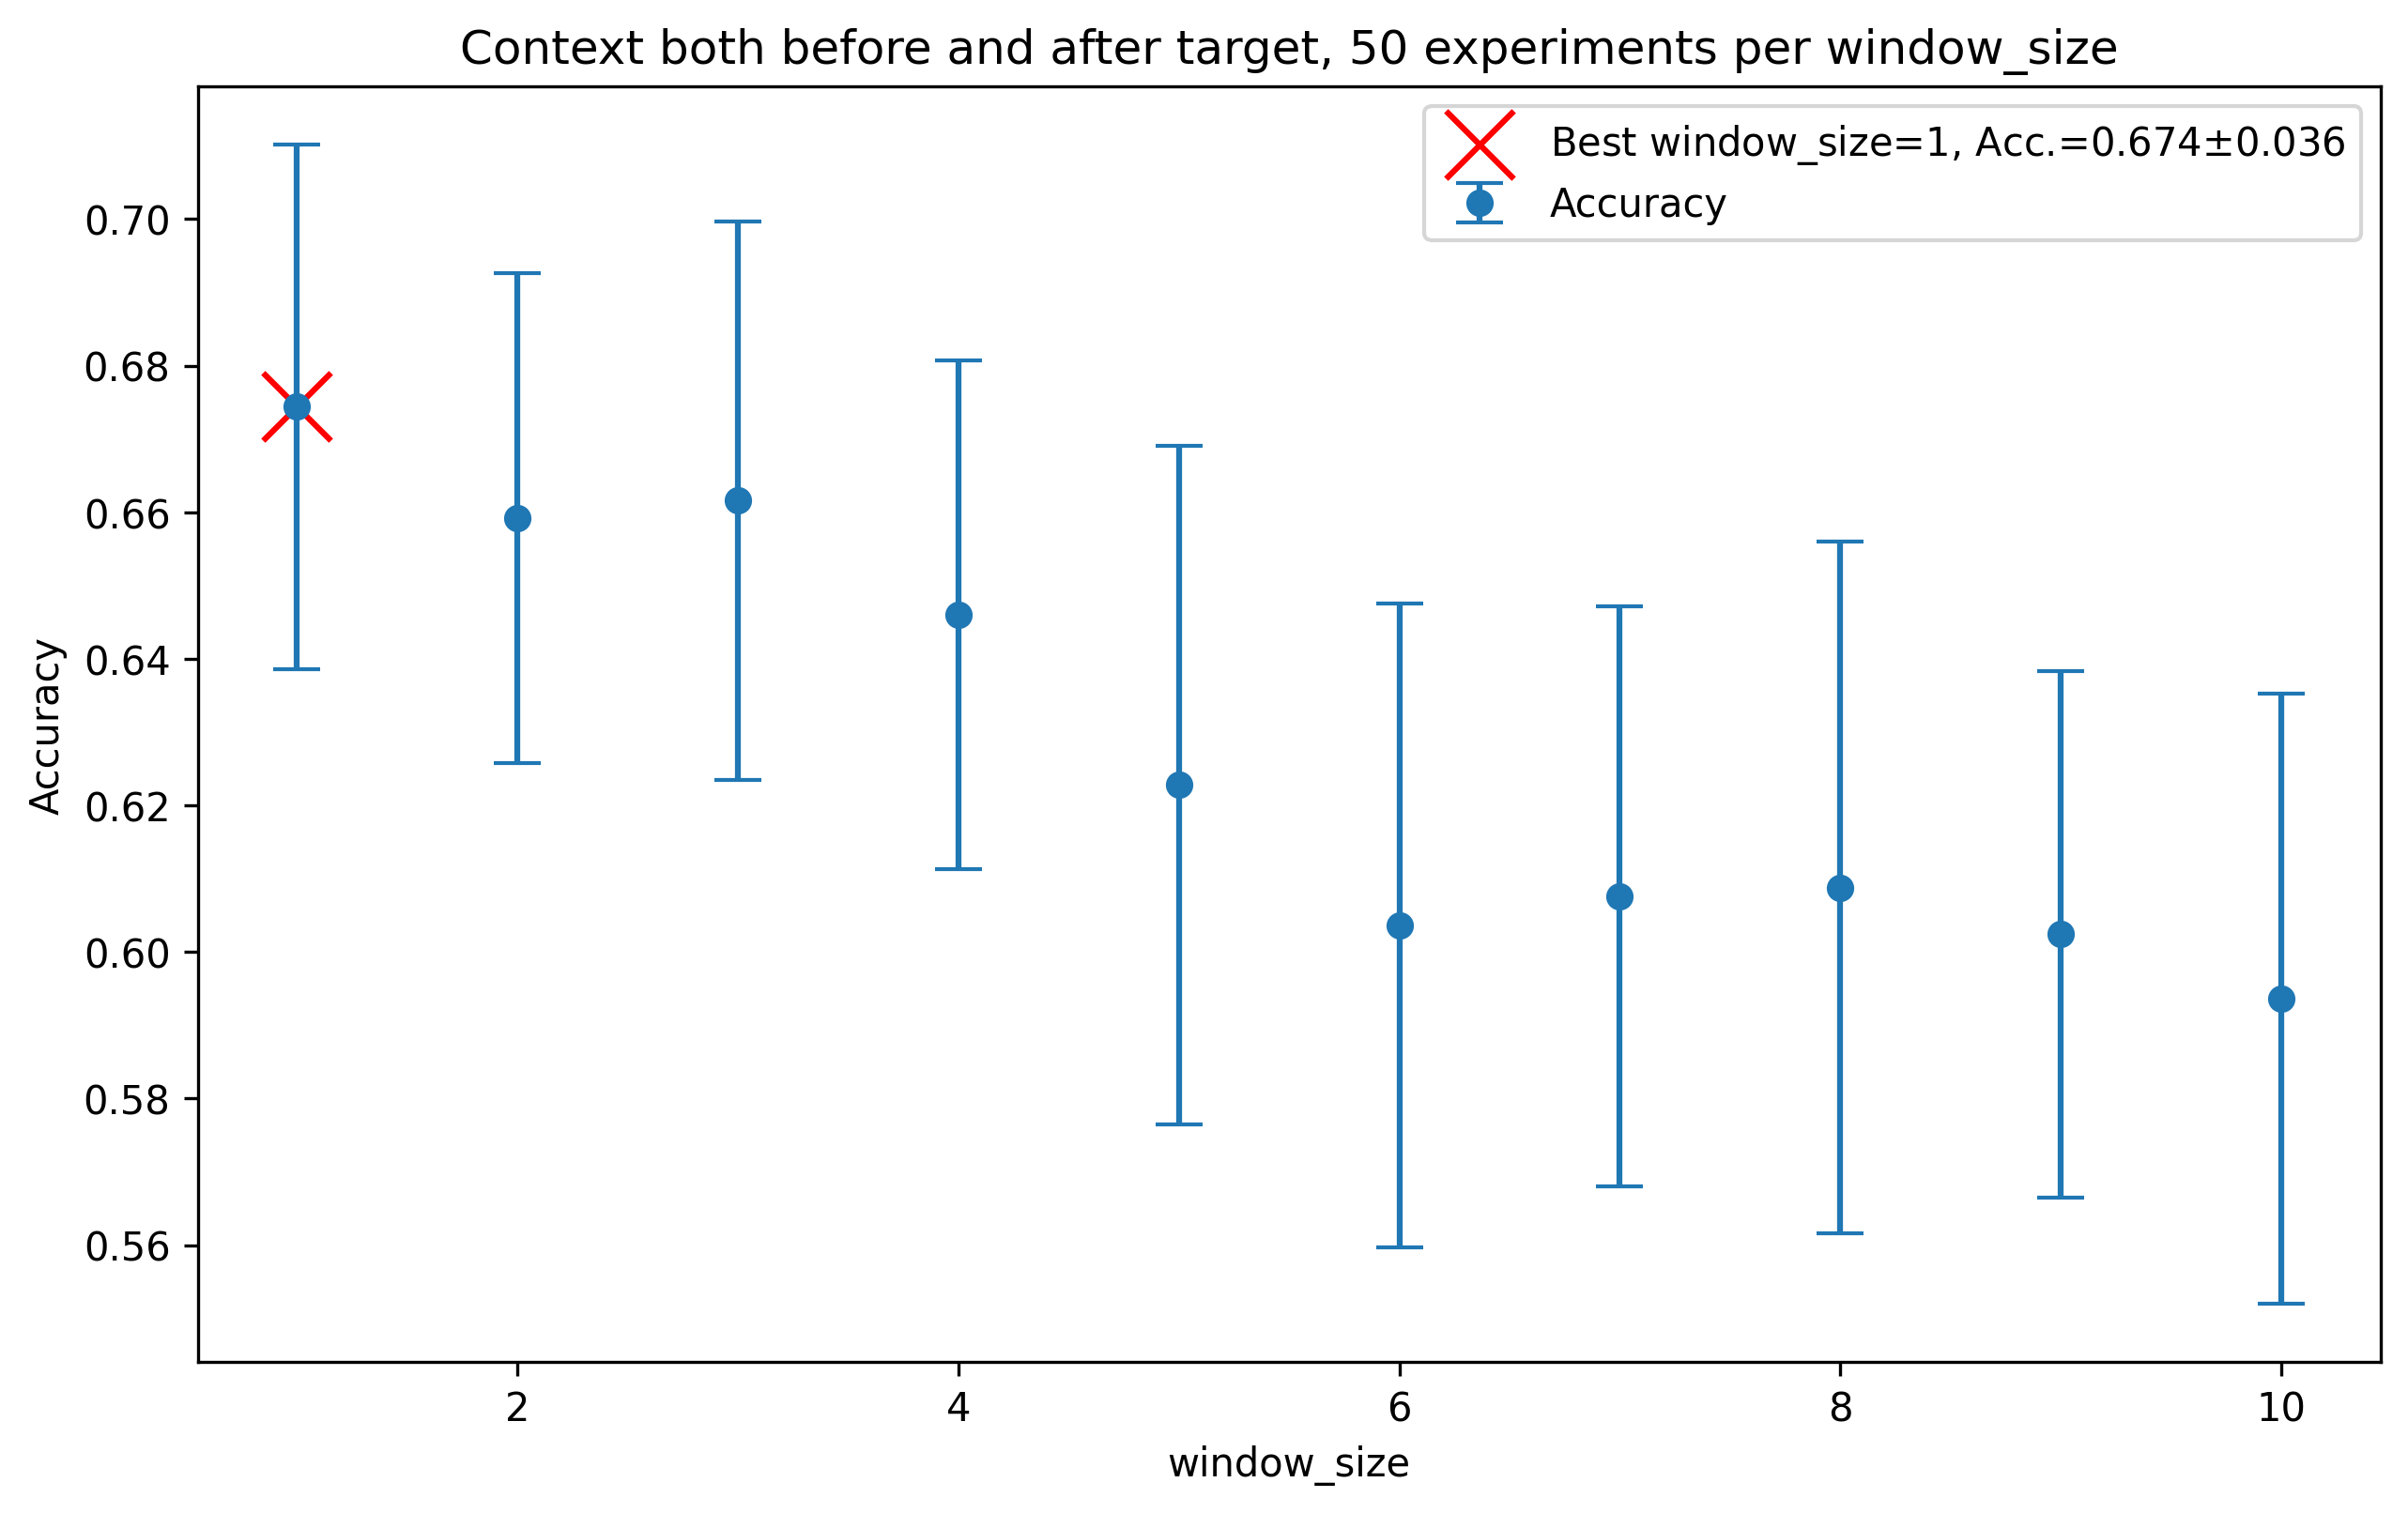

In [21]:
CONTEXT_AFTER = True #context only before and after too. with True, the norm of the embedding matrix will be around 2x larger
NUM_EXPERIMENTS_PER_WINDOW = 10  #how many random pseudoword swap averages to calculate the accuracies, feel free to lower
NUM_WORDS_TO_CLUSTER = 50

window_sizes = np.arange(1, 11, 1) #definitely does not get better after 10, feel free to lower

window_size_accuracies = []
window_size_accuracy_stds = []

for window_size in tqdm(window_sizes):
    current_accuracies = []
    for _ in range(NUM_EXPERIMENTS_PER_WINDOW):
        exp_string_dictionary, exp_tokens = glove_setup()
        experiment_accuracy, _ = glove_experiment(
            review_string_dictionary=exp_string_dictionary,
            original_corpus_tokens = exp_tokens,
            window_size=window_size,
            context_after=CONTEXT_AFTER,
        )
        current_accuracies.append(experiment_accuracy)
    window_size_accuracies.append(np.mean(current_accuracies))
    window_size_accuracy_stds.append(np.std(current_accuracies))
    
best_window_size_idx = np.argmax(window_size_accuracies)

fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)

ax.errorbar(
    window_sizes,
    window_size_accuracies,
    window_size_accuracy_stds,
    fmt="o",
    label="Accuracy",
    capsize=6,
)

ax.scatter(
    window_sizes[best_window_size_idx],
    window_size_accuracies[best_window_size_idx],
    marker="x",
    label=r"Best window_size="
    + str(window_sizes[best_window_size_idx])
    + ", Acc.="
    + str(np.round(window_size_accuracies[best_window_size_idx], 3))
    + r"$\pm$"
    + str(np.round(window_size_accuracy_stds[best_window_size_idx], 3)),
    c="r",
    s=300,
    alpha=1,
)

ax.set_title(
    "Context both before and after target, "
    + str(NUM_EXPERIMENTS_PER_WINDOW)
    + " experiments per window_size"
)
ax.set_xlabel(r"window_size")
ax.legend(loc="best")
ax.set_ylabel("Accuracy")

PCA from 300 to 2D won't be amazing, but can clearly see correlation of some points clustered together (although we're out of colours):

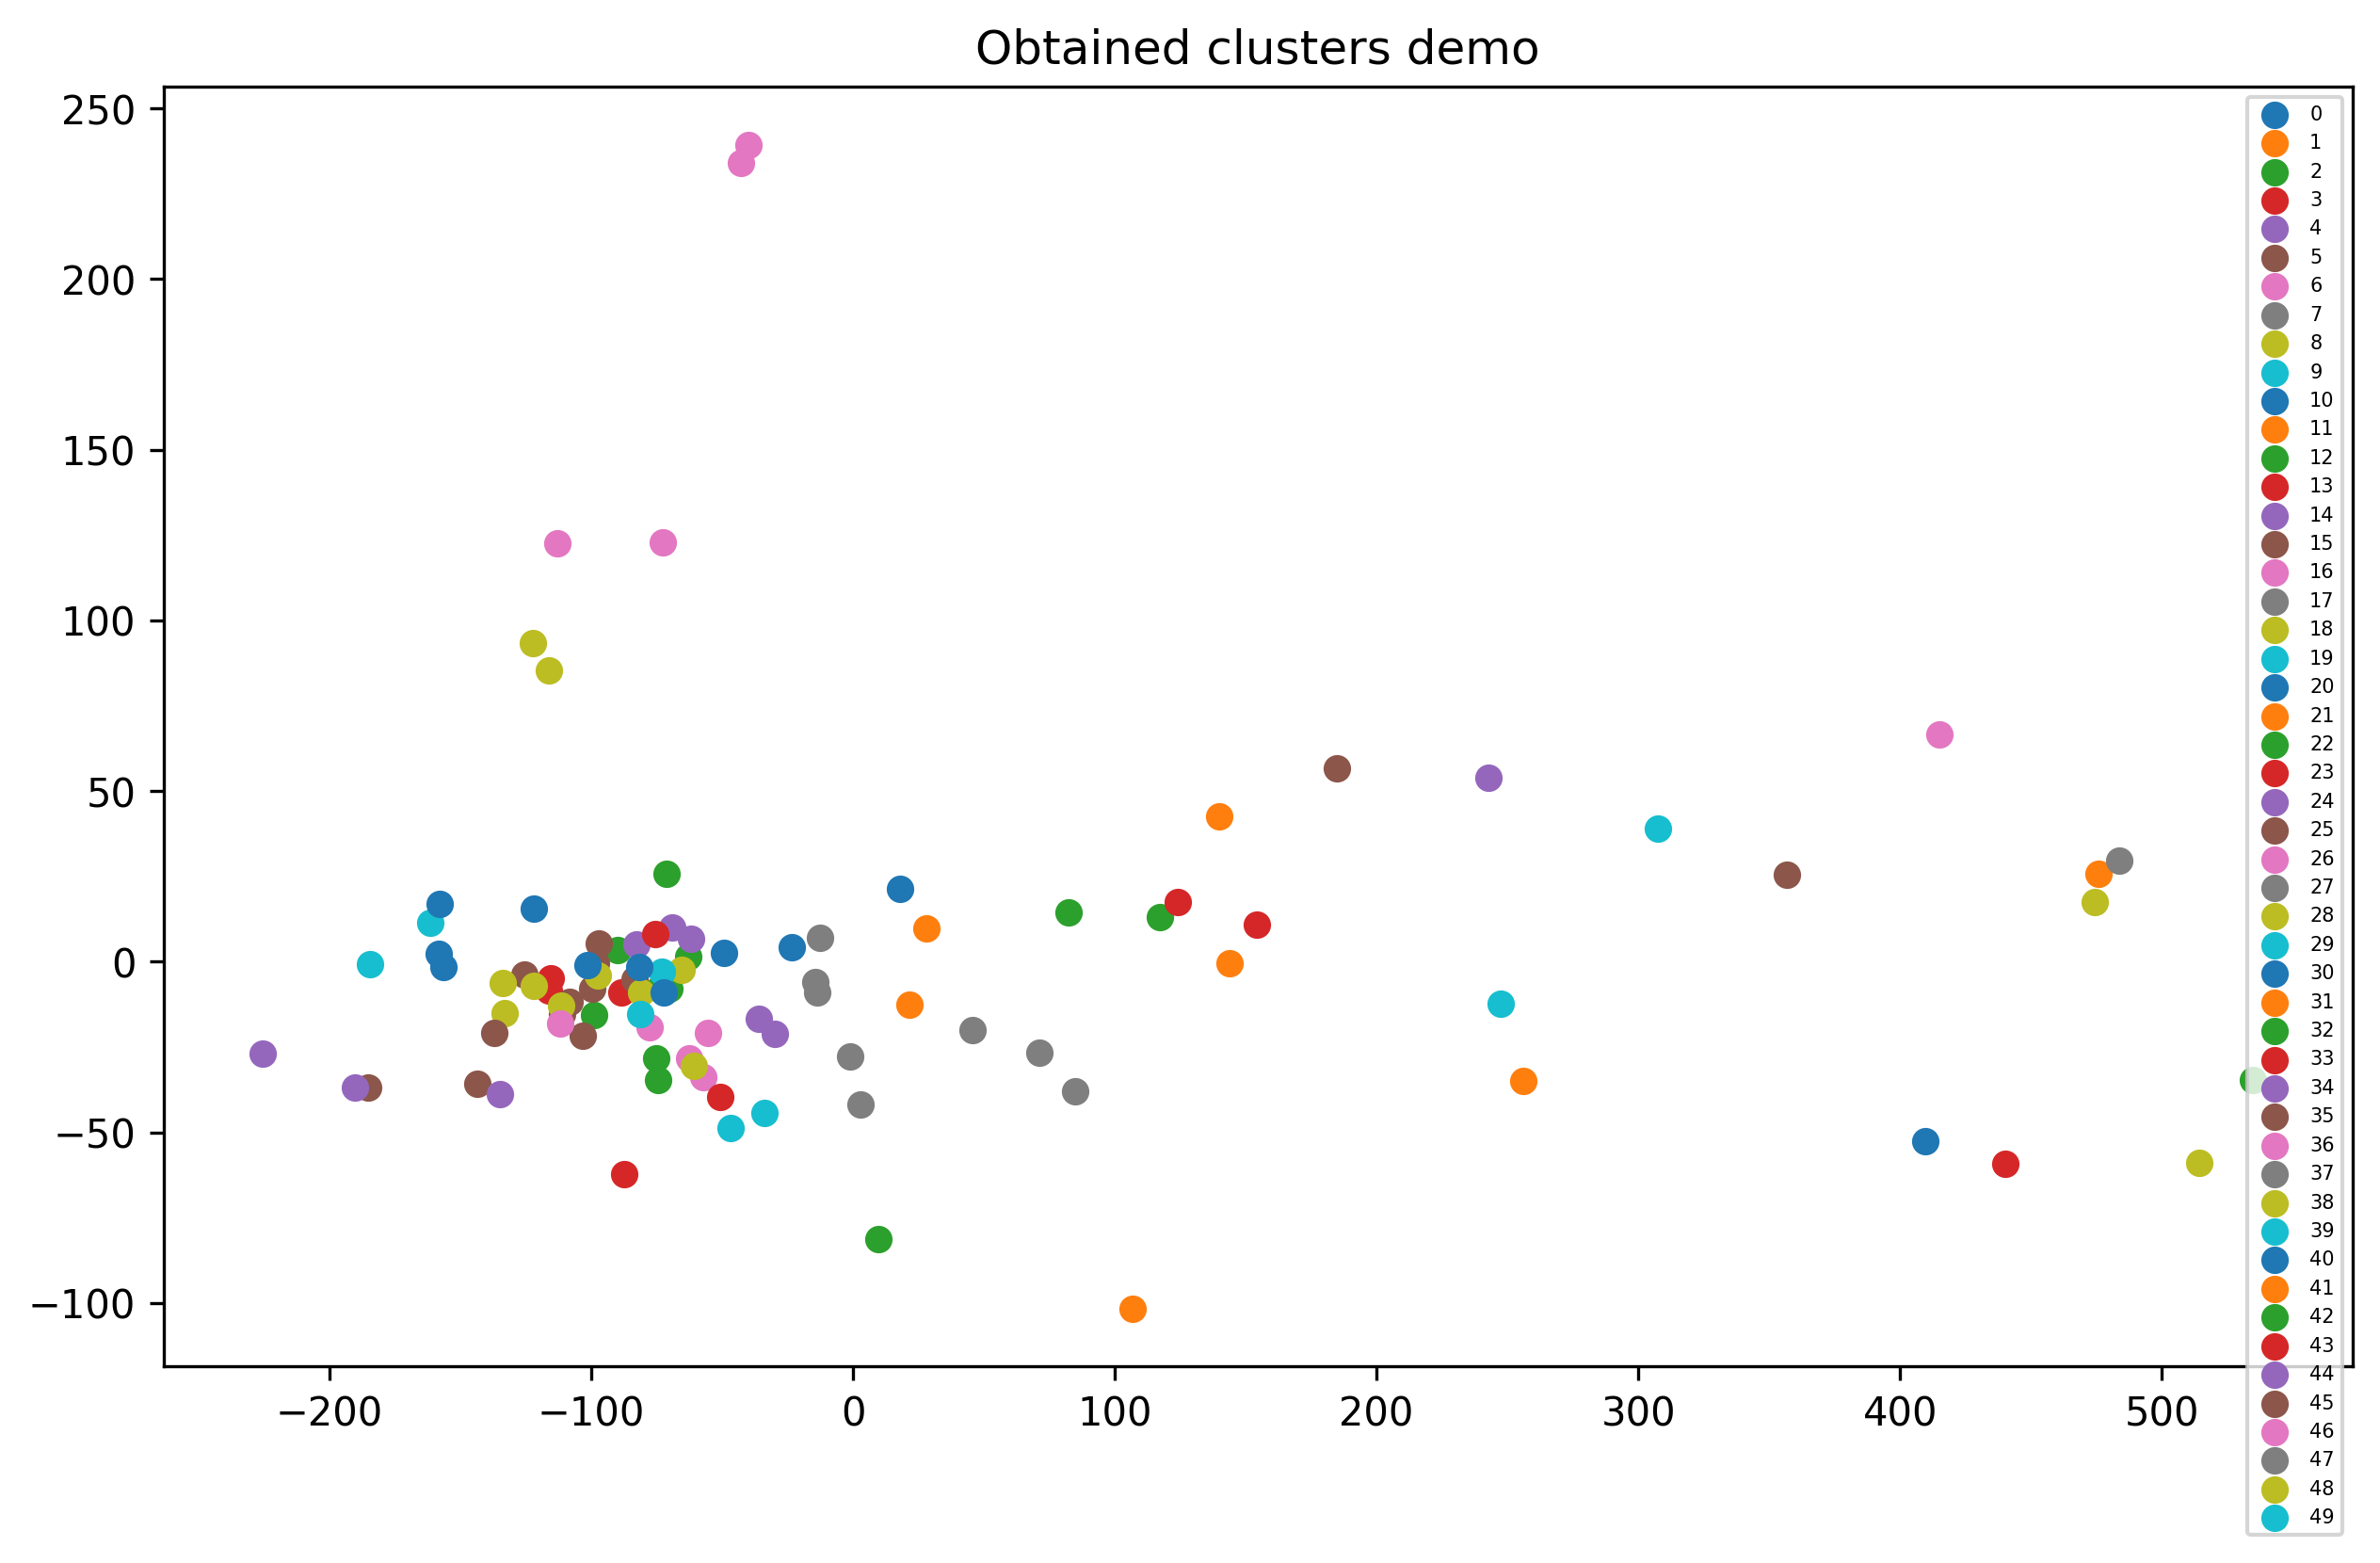

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

exp_string_dictionary, exp_tokens = glove_setup()
_, matrix_to_pca = glove_experiment(
    review_string_dictionary=exp_string_dictionary,
    original_corpus_tokens = exp_tokens,
    window_size=window_sizes[best_window_size_idx],
    context_after=CONTEXT_AFTER,
)

pca = PCA(n_components=NUM_WORDS_TO_CLUSTER)
pcs = pca.fit_transform(matrix_to_pca)
pc1_values = pcs[:,0]
pc2_values = pcs[:,1]

clustering_model = AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward') #ward does not work for cosine,
# which is default for NLTK and should be better, but this is just a demo
clustering_model.fit(matrix_to_pca)
clustering_model.labels_
data_labels = clustering_model.labels_

fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)
scatter_x = pc1_values
scatter_y = pc2_values
group = data_labels

for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g)
ax.legend(loc="best", prop={'size': 5})
ax.set_title(
    "Obtained clusters demo"
)
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Accuracy')

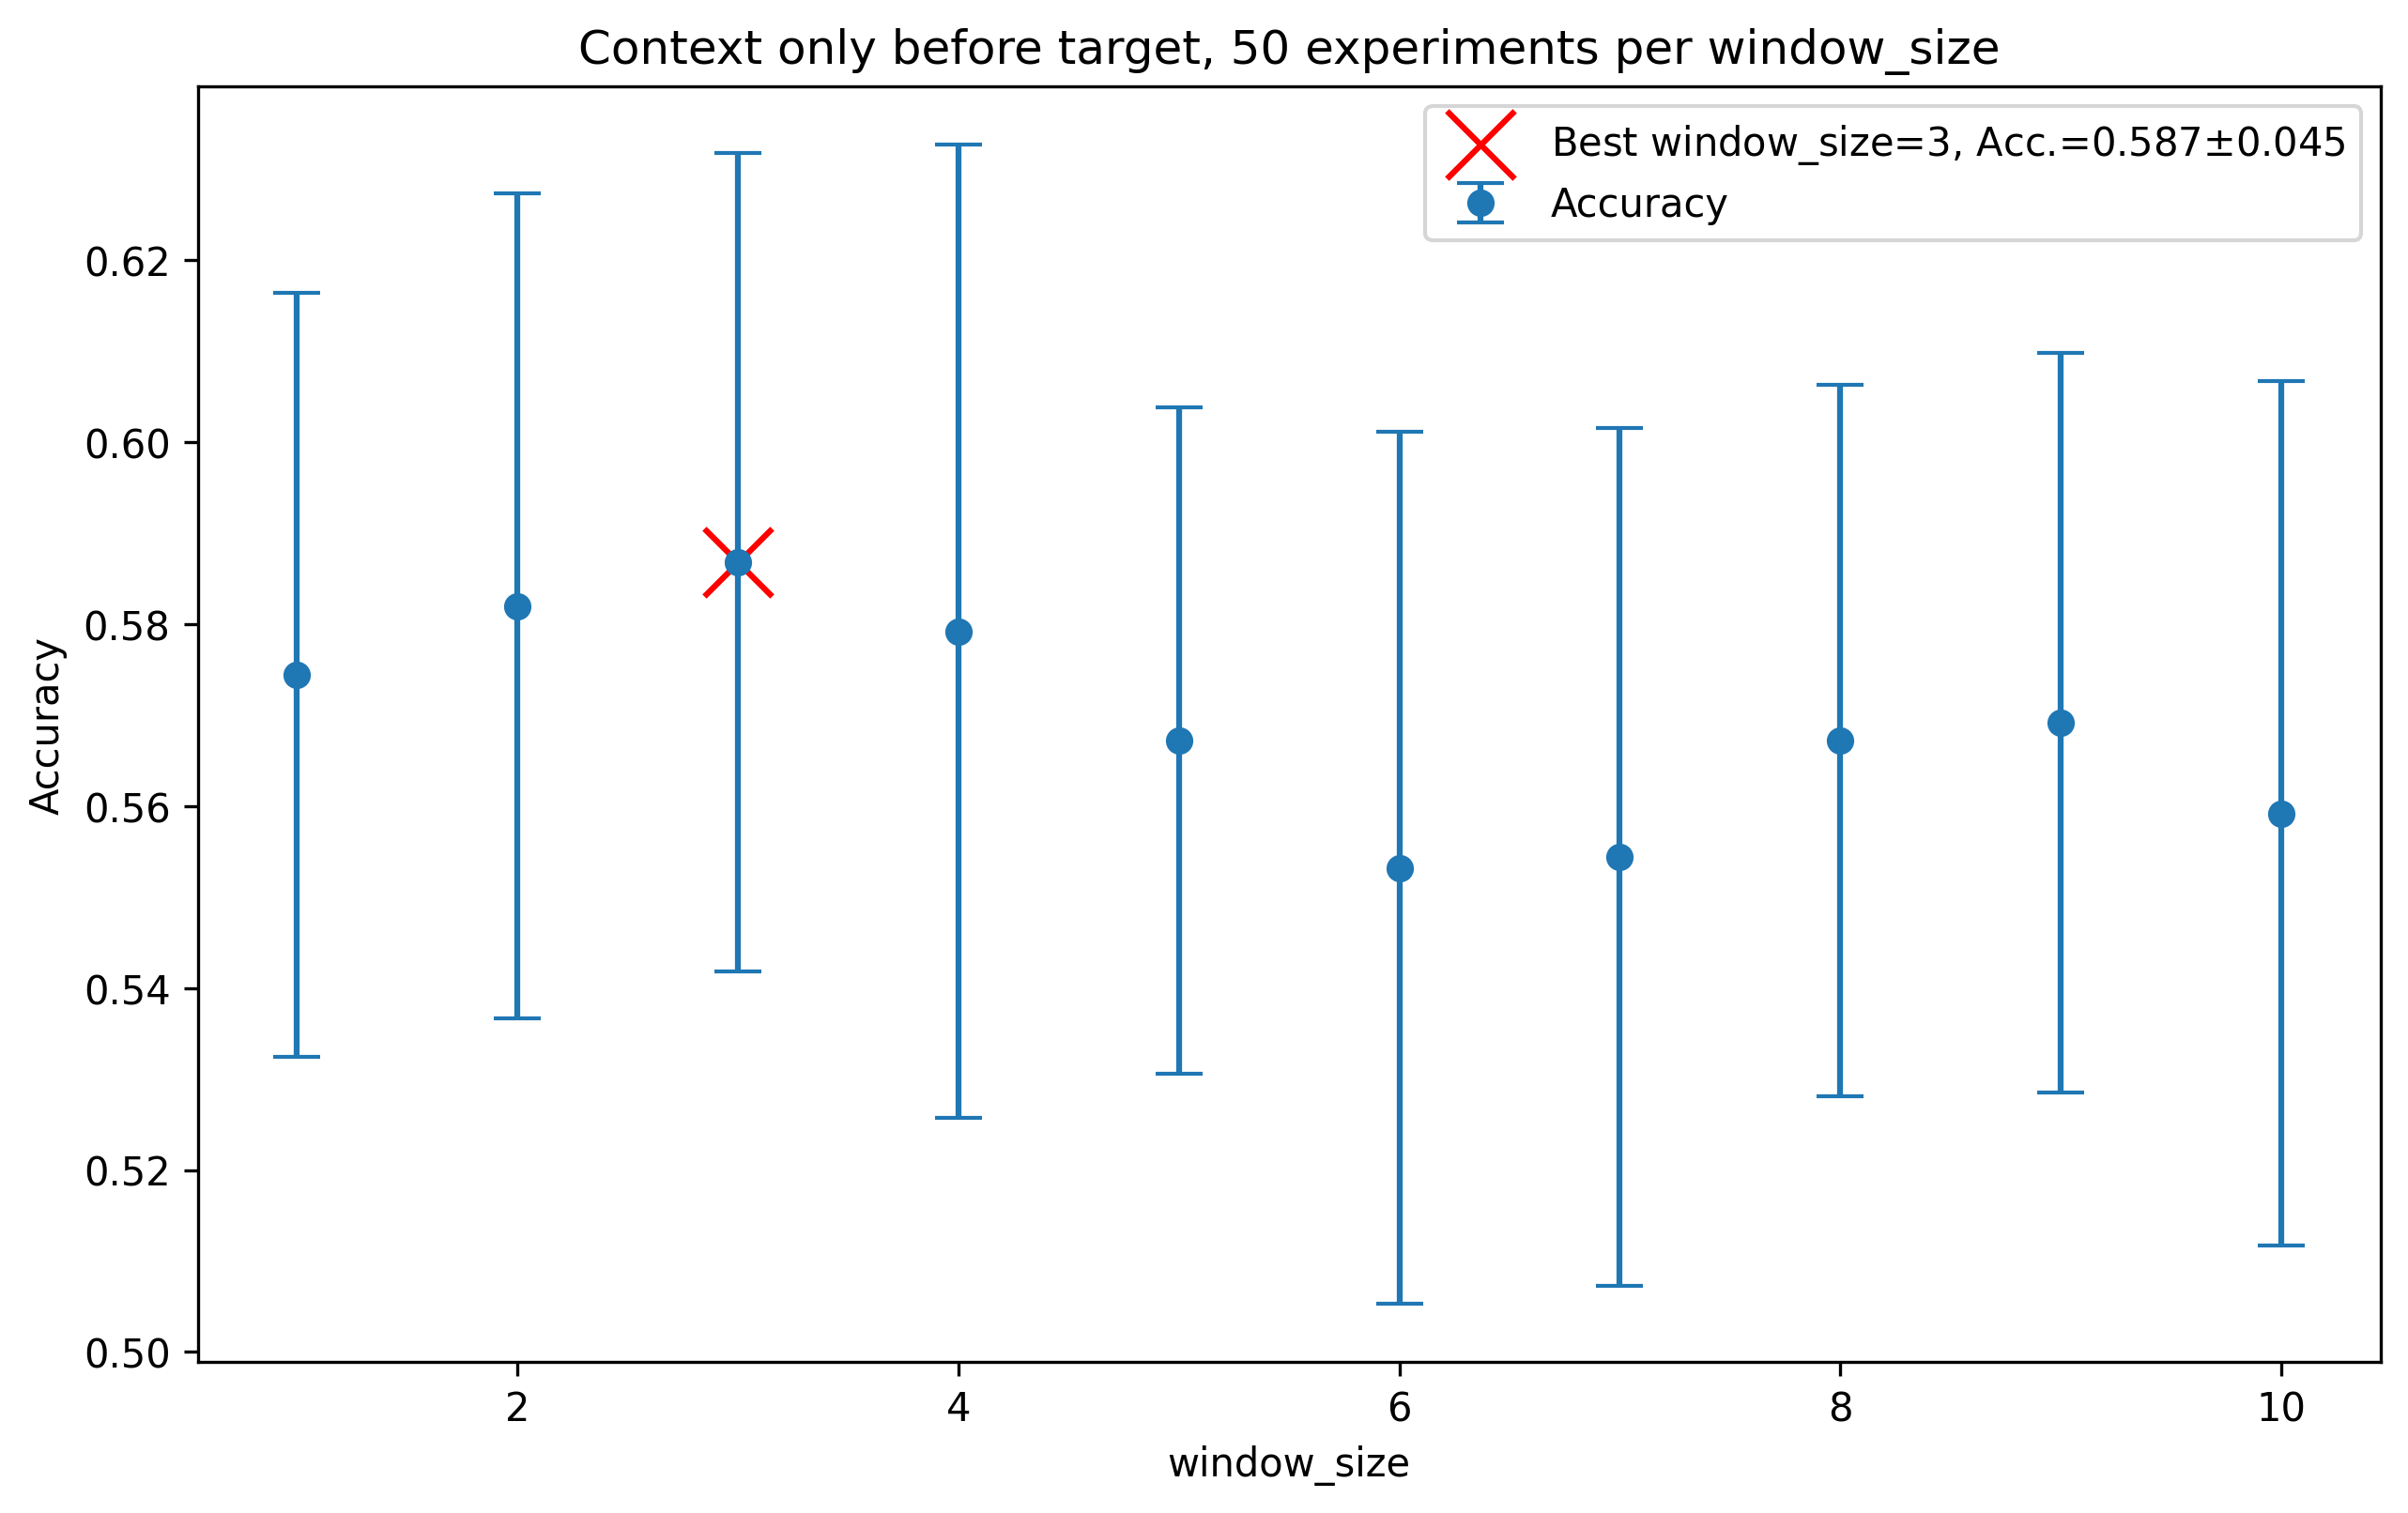

In [20]:
CONTEXT_AFTER = False #context only before and after too. with True, the norm of the embedding matrix will be around 2x larger
NUM_EXPERIMENTS_PER_WINDOW = 50  #how many random pseudoword swap averages to calculate the accuracies, feel free to lower
NUM_WORDS_TO_CLUSTER = 50

window_sizes = np.arange(1, 11, 1) #definitely does not get better after 10, feel free to lower

window_size_accuracies = []
window_size_accuracy_stds = []

for window_size in tqdm(window_sizes):
    current_accuracies = []
    for _ in range(NUM_EXPERIMENTS_PER_WINDOW):
        exp_string_dictionary, exp_tokens = glove_setup()
        experiment_accuracy, _ = glove_experiment(
            review_string_dictionary=exp_string_dictionary,
            original_corpus_tokens = exp_tokens,
            window_size=window_size,
            context_after=CONTEXT_AFTER,
        )
        current_accuracies.append(experiment_accuracy)
    window_size_accuracies.append(np.mean(current_accuracies))
    window_size_accuracy_stds.append(np.std(current_accuracies))
best_window_size_idx = np.argmax(window_size_accuracies)

fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)

ax.errorbar(
    window_sizes,
    window_size_accuracies,
    window_size_accuracy_stds,
    fmt="o",
    label="Accuracy",
    capsize=6,
)

ax.scatter(
    window_sizes[best_window_size_idx],
    window_size_accuracies[best_window_size_idx],
    marker="x",
    label=r"Best window_size="
    + str(window_sizes[best_window_size_idx])
    + ", Acc.="
    + str(np.round(window_size_accuracies[best_window_size_idx], 3))
    + r"$\pm$"
    + str(np.round(window_size_accuracy_stds[best_window_size_idx], 3)),
    c="r",
    s=300,
    alpha=1,
)

ax.set_title(
    "Context only before target, "
    + str(NUM_EXPERIMENTS_PER_WINDOW)
    + " experiments per window_size"
)
ax.set_xlabel(r"window_size")
ax.legend(loc="best")
ax.set_ylabel("Accuracy")
